### Quick set of analysis tools to scope single cell runs in LANDIS

In [257]:
%matplotlib inline
# Libraries -- overkill for the time being
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime, gdal

# Set working dir
wrkDir = 'C:/Research/Dinkey_Creek/Dinkey_SingleCells/'

# Century file name
centoutput = 'Century-succession-log.csv'

# Species biomass file name
speciesbiooutput = 'spp-biomass-log.csv'

# Thin log
thinlog = '\Thin\summarylog.csv'

# fire log
firelog = 'dynamic-fire-test-log.csv'

sns.set_style("ticks")
sns.set_context('notebook', font_scale=1.3)

### Read in files of interest, do some data management
Read in the century annual output files, the thin and fire logs, and the species biomass output log. 

In [258]:
# Scenario name (name of the folder containing the run)
scenario = 'Shrubs_ThinRxFire'

# Read in century output, delete any erronious columns
centuryOutput = pd.read_csv(wrkDir + scenario + '/' + centoutput)
for col in centuryOutput.columns:
    if 'Unnamed' in col:
        del centuryOutput[col]

# Read in the species biomass log, delete any erronious columns
sppBio = pd.read_csv(wrkDir + scenario + '/' + speciesbiooutput)
for col in sppBio.columns:
    if 'Unnamed' in col:
        del sppBio[col]

# Clean up the species biomass log to contain only columns that are not all NaN
# Remove allcolumns except for the species biomass values (single cell run, no need for
# ecoregion, timestep, etc.)
sppB = sppBio.ix[:,4:]
sppB[sppB == 0] = np.nan
sppB = sppB.dropna(axis='columns', how='all')

# Convert g / m^2 to Mg / ha, then convert AGB to C
sppB = sppB * 0.01 * 0.5

# Read in the fire log
flog = pd.read_csv(wrkDir + scenario + '/' + firelog)

# Read in the fire log
tlog = pd.read_csv(wrkDir + scenario + '/' + thinlog)

### Species specific biomass trajectories
Two plots, first showing the total AGB (in Mg C per hectare), of the species represented in the run. The plot is stacked, showing total AGB (C) on the Y axis. The second plot is a stacked area plot, where at each time point the % of total biomass for a given species is represented by the Y axis.

In [259]:
check = flog[flog.Time == fireYear].MeanSeverity.astype('str')
check.ravel()[0]

'1.5'

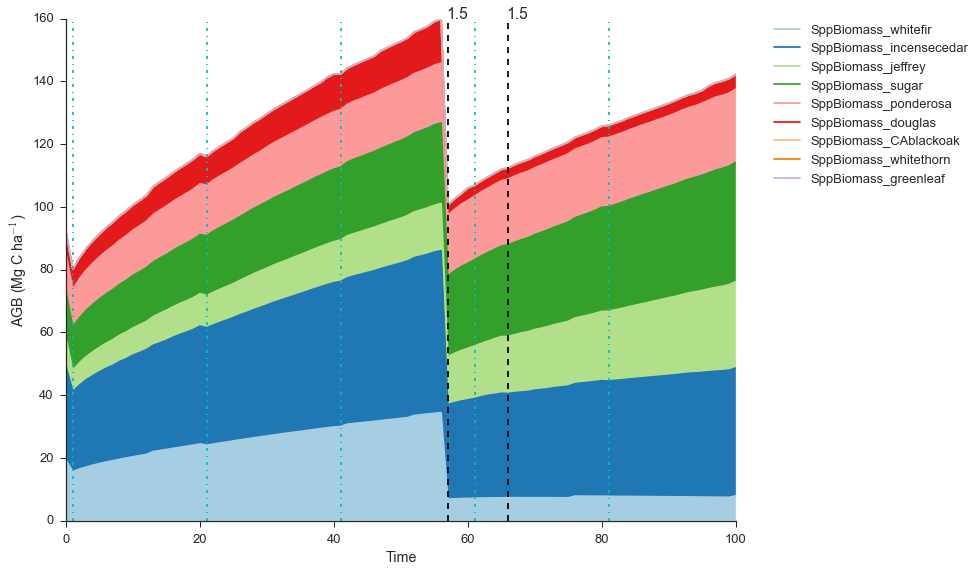

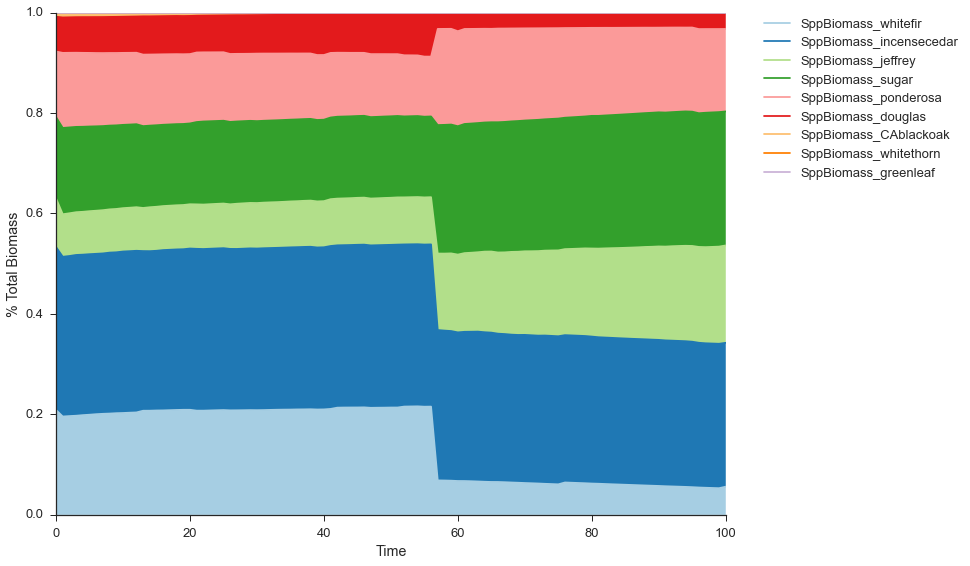

In [260]:
# Species color map -- 9 value quantitative map ColorBrewer
sppColors = ['#a6cee3','#1f78b4','#b2df8a',
             '#33a02c','#fb9a99','#e31a1c',
             '#fdbf6f','#ff7f00','#cab2d6']

# Stacked line plot
f, (ax) = plt.subplots(1,1, figsize=(12, 9))
sppB.plot(ax = ax, kind = 'Area', color = sppColors)
ax.set_ylabel('AGB (Mg C ha$^{-1}$)')
ax.set_xlabel('Time')
maxY = ax.get_ylim()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine()

# Annotate fires and thinning treatments along the time series
for fireYear in flog.Time:
    severity = flog[flog.Time == fireYear].MeanSeverity
    ax.annotate((str(severity.ravel()[0])), xy=(fireYear, maxY[1]))
    ax.axvline(fireYear, color='k', linestyle='--')
    
for mgmtYear in tlog.Time:
    prescrip = tlog[tlog.Time == mgmtYear].Prescription
    #ax.annotate(prescrip, xy=(mgmtYear, maxY[1]))
    ax.axvline(mgmtYear, color='c', linestyle='-.')


# 100% Area plot
f, (ax) = plt.subplots(1,1, figsize=(12, 9))

# Divide each element by the sum of every row
sppRelB = sppB.divide(sppB.sum(axis=1), axis=0)

sppRelB.plot(ax = ax, kind = 'Area', color = sppColors)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('% Total Biomass')
ax.set_xlabel('Time')
ax.set_ylim([0,1])
sns.despine()


### Illustrate the corresponding fuel type designated by the DFFS in LANDIS


In [261]:
def rasterStack(rasterLoc, mapname, runLength):
    rasterlist = []
    timesteps = np.linspace(1,runLength,runLength)
    for time in timesteps:  
        rastermap = mapname + str(int(time)) + '.img'
        src_ds = gdal.Open( rasterLoc + rastermap )
        rasterarray = src_ds.ReadAsArray()
        rasterarray = rasterarray.astype('float')
        rasterlist.append(rasterarray)
            
    return rasterlist


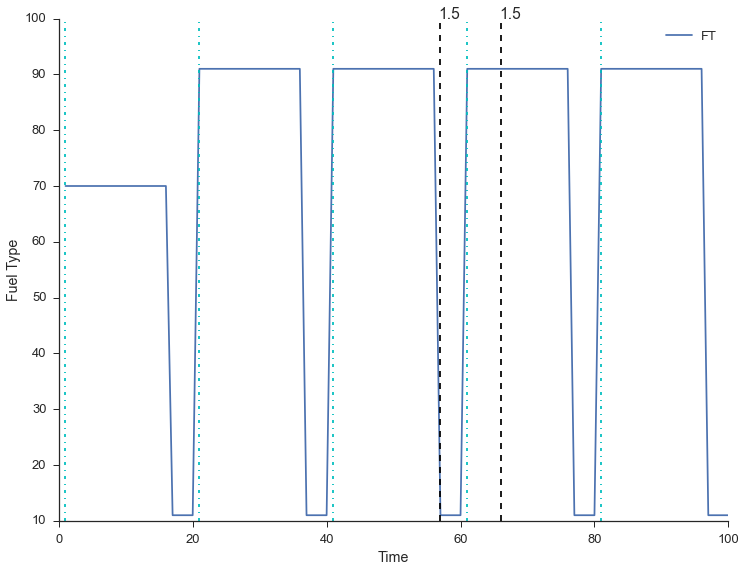

In [263]:
fuelTypes = rasterStack(wrkDir + scenario + '/fire/', 'FuelType-', 100)
FT_TS = np.dstack(fuelTypes)
FT_TS = FT_TS - 1
Years = np.arange(1,101,1)
FTs = pd.DataFrame(dict(FT = FT_TS[0][0]), index = Years)
f, (ax) = plt.subplots(1,1, figsize=(12, 9))
FTs.plot(ax = ax)
ax.set_xlim([0,100])
# Annotate fires and thinning treatments along the time series
maxY = ax.get_ylim()
for fireYear in flog.Time:
    severity = flog[flog.Time == fireYear].MeanSeverity
    ax.annotate((str(severity.ravel()[0])), xy=(fireYear, maxY[1]))
    ax.axvline(fireYear, color='k', linestyle='--')
    
for mgmtYear in tlog.Time:
    prescrip = tlog[tlog.Time == mgmtYear].Prescription
    #ax.annotate(prescrip, xy=(mgmtYear, maxY[1]))
    ax.axvline(mgmtYear, color='c', linestyle='-.')

ax.set_ylabel('Fuel Type')
ax.set_xlabel('Time')
sns.despine()